In [99]:
from cProfile import label
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
from sympy import *
import scipy as sp
import sys
sys.path.append('..')

from libka import *

In [100]:
I_ZASILACZ = 2.00 * 10**(-3) # A
U_NIESYMETRYZACJI = -0.63 #mV dla Icewki =0
PODZIALKA_HALLA = 0.1 # A
d = 0.3 * 10**(-6) # m
e = 1.602 * 10**(-19) # C

# check unit of sigma
SIGMA = 30516.43192488263 # 1/(Ohm*m) 

LENGTH = 7.8 * 10**(-3) # m
AA = 4 * 10**(-3) # m
DD = 0.3 * 10**(-6) # m

In [101]:
df = pd.read_csv("in/dataI2.csv", names = ["I", "U mV"], header = 0)


In [102]:
df["U"] = df["U mV"] * 10**(-3) # V
df["B"] = 0.00673 + 0.18548 * df["I"] + 0.00217 * df["I"]**2 - 0.00318 * df["I"]**3 + 2.00009 * 10**(-4) * df["I"]**4

df["uI"] = typeB(PODZIALKA_HALLA, PODZIALKA_HALLA/2)
df["uU"] = 0.03/100*df["U"] + 0.01 * 10**(-3) # V
df["uB"] = (0.18548 + 2 * 0.00217 * df["I"] - 3 * 0.00318 * df["I"]**2 + 4* 2.00009 * 10**(-4) * df["I"]**3) * df["uI"]

In [103]:
df2 = pd.read_csv('in/resistance.csv', names = ["II", "Up", "Uw"], header = 0)
new_df = pd.concat([df, df2], axis = 1)
new_df.pop("II")

new_df["uUp"] = 0.03/100*new_df["Up"] + 0.01 * 10**(-3) # V
new_df["uUw"] = 0.03/100*new_df["Uw"] + 0.01 * 10**(-3) # V

new_df["Rp"] = new_df["Up"] / I_ZASILACZ
new_df["Rw"] = new_df["Uw"] / I_ZASILACZ

new_df["sig"] = 1 / new_df["Rp"] * LENGTH / AA / DD

sig0 = new_df["sig"][0]
Ux0 = new_df["Up"][0]
uUx0 = new_df["uUp"][0]

new_df

,I,U mV,U,B,uI,uU,uB,Up,Uw,uUp,uUw,Rp,Rw,sig
0,0.0,-0.63,-0.00063,0.006730,0.06455,0.000010,0.011973,0.4260,0.2006,0.000138,0.00007,213.00,100.30,30516.431925
1,0.5,3.77,0.00377,0.099628,0.06455,0.000011,0.011965,0.4308,0.2007,0.000139,0.00007,215.40,100.35,30176.415970
2,1.0,8.48,0.00848,0.191400,0.06455,0.000013,0.011689,0.4322,0.2007,0.000140,0.00007,216.10,100.35,30078.667284
3,1.5,12.80,0.01280,0.280113,0.06455,0.000014,0.011182,0.4344,0.2007,0.000140,0.00007,217.20,100.35,29926.335175
4,2.0,17.18,0.01718,0.364130,0.06455,0.000015,0.010483,0.4376,0.2007,0.000141,0.00007,218.80,100.35,29707.495430
5,2.5,21.34,0.02134,0.442118,0.06455,0.000016,0.009631,0.4411,0.2008,0.000142,0.00007,220.55,100.40,29471.775108
6,3.0,25.08,0.02508,0.513041,0.06455,0.000018,0.008665,0.4449,0.2007,0.000143,0.00007,222.45,100.35,29220.049449
7,3.5,28.21,0.02821,0.576164,0.06455,0.000018,0.007624,0.4483,0.2007,0.000144,0.00007,224.15,100.35,28998.438546
8,4.0,30.78,0.03078,0.631052,0.06455,0.000019,0.006545,0.4513,0.2006,0.000145,0.00007,225.65,100.30,28805.672502
9,4.5,32.75,0.03275,0.677571,0.06455,0.000020,0.005469,0.4538,0.2006,0.000146,0.00007,226.90,100.30,28646.981049


In [104]:
# new_df.drop(new_df.index[0], inplace = True)
# new_df.reset_index(drop = True, inplace = True)


In [105]:
new_df['dSig'] = sig0 - new_df['sig']

new_df['dSig/sig'] = new_df['dSig']/new_df['sig']
new_df["(Ux-U)/U"] = (new_df["Up"] - Ux0) / Ux0

new_df["u(Ux-U/U)"] = np.sqrt((1/Ux0*new_df["uUp"])**2 + (new_df["Up"]/(Ux0**2)*uUx0)**2)
new_df["B2"] = new_df["B"]**2
new_df["uB2"] = 2*new_df["B"]*new_df["uB"]
# ktora wartosc wybrac?
#Brak uUw i wszystkich wartości dla 0.0

new_df

,I,U mV,U,B,uI,uU,uB,Up,Uw,uUp,uUw,Rp,Rw,sig,dSig,dSig/sig,(Ux-U)/U,u(Ux-U/U),B2,uB2
0,0.0,-0.63,-0.00063,0.006730,0.06455,0.000010,0.011973,0.4260,0.2006,0.000138,0.00007,213.00,100.30,30516.431925,0.000000,0.000000,0.000000,0.000457,0.000045,0.000161
1,0.5,3.77,0.00377,0.099628,0.06455,0.000011,0.011965,0.4308,0.2007,0.000139,0.00007,215.40,100.35,30176.415970,340.015955,0.011268,0.011268,0.000462,0.009926,0.002384
2,1.0,8.48,0.00848,0.191400,0.06455,0.000013,0.011689,0.4322,0.2007,0.000140,0.00007,216.10,100.35,30078.667284,437.764641,0.014554,0.014554,0.000464,0.036634,0.004474
3,1.5,12.80,0.01280,0.280113,0.06455,0.000014,0.011182,0.4344,0.2007,0.000140,0.00007,217.20,100.35,29926.335175,590.096750,0.019718,0.019718,0.000466,0.078463,0.006264
4,2.0,17.18,0.01718,0.364130,0.06455,0.000015,0.010483,0.4376,0.2007,0.000141,0.00007,218.80,100.35,29707.495430,808.936495,0.027230,0.027230,0.000469,0.132591,0.007634
5,2.5,21.34,0.02134,0.442118,0.06455,0.000016,0.009631,0.4411,0.2008,0.000142,0.00007,220.55,100.40,29471.775108,1044.656817,0.035446,0.035446,0.000473,0.195468,0.008516
6,3.0,25.08,0.02508,0.513041,0.06455,0.000018,0.008665,0.4449,0.2007,0.000143,0.00007,222.45,100.35,29220.049449,1296.382476,0.044366,0.044366,0.000477,0.263211,0.008891
7,3.5,28.21,0.02821,0.576164,0.06455,0.000018,0.007624,0.4483,0.2007,0.000144,0.00007,224.15,100.35,28998.438546,1517.993379,0.052347,0.052347,0.000481,0.331965,0.008785
8,4.0,30.78,0.03078,0.631052,0.06455,0.000019,0.006545,0.4513,0.2006,0.000145,0.00007,225.65,100.30,28805.672502,1710.759423,0.059390,0.059390,0.000484,0.398227,0.008261
9,4.5,32.75,0.03275,0.677571,0.06455,0.000020,0.005469,0.4538,0.2006,0.000146,0.00007,226.90,100.30,28646.981049,1869.450876,0.065258,0.065258,0.000486,0.459103,0.007412


In [106]:
a, b, ua, ub, chi2 = least_squares(df["B"], df["U"], df["uU"], 0, len(df.index)-1)

print("a = ", a, ", ua = ", ua)
print("b = ", b, ", ub = ", ub)
print("chi2 = ", chi2)

a =  0.050241184265928183 , ua =  1.7472931936862524e-05
b =  -0.0010796435868755119 , ub =  6.959296075205433e-06
chi2 =  32706.400393477285


In [107]:
# Rh = d/a/I_ZASILACZ
# uRh = d/I_ZASILACZ/a/a * ua

Rh = a*d/I_ZASILACZ
uRh = d/I_ZASILACZ * ua

print("Rh = ", Rh, ", uRh = ", uRh)

Rh =  7.536177639889227e-06 , uRh =  2.6209397905293786e-09


In [108]:
a2, b2, ua2, ub2, chi22 = least_squares(new_df["B2"], new_df["(Ux-U)/U"], new_df["u(Ux-U/U)"], 0, len(new_df.index)-1)

print("a = ", a2, ", ua = ", ua2)
print("b = ", b2, ", ub = ", ub2)
print("chi2 = ", chi22)

a =  0.12478086782331735 , ua =  0.0007154687076050151
b =  0.008663424120457402 , ub =  0.000218962626731702
chi2 =  6274.977638617928


In [109]:
# idk if i should take r or not, look at page nr 4
# przyjmujemy tylko jeden rodzaj nosnikow

n = 1/Rh/e
un = 1/e/Rh/Rh * uRh

print("n = ", n, ", un = ", un)

mu = SIGMA/n/e
umu = SIGMA/e /n/n * un

print("mu = ", mu, ", umu = ", umu)

n =  8.282975205352194e+23 , un =  2.8806618337615135e+20
mu =  0.2299772519215022 , umu =  7.998173069690591e-05


In [110]:
wspolczynnikA = a2/(mu**2)
uA = a2/(mu**3) * umu
print("wspolczynnikA = ", wspolczynnikA, ", uA = ", uA) 

wspolczynnikA =  2.3592732384036244 , uA =  0.0008205105297058861


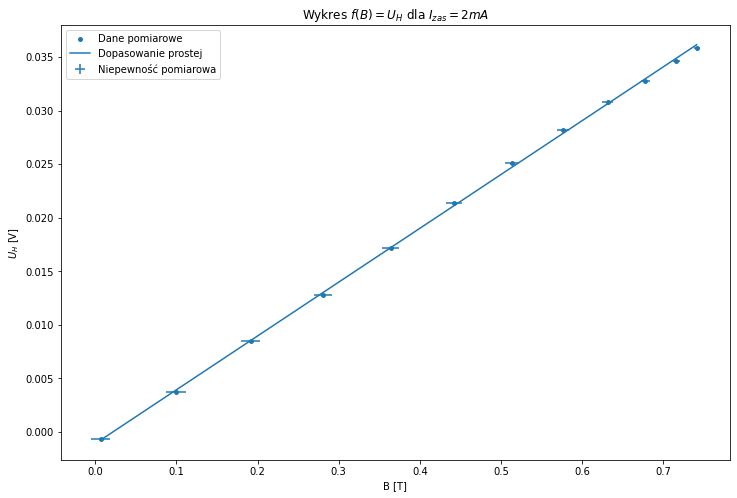

In [111]:
fig, ax = plt.subplots(figsize = (12, 8)) # add scienitfic notation for x axe
ax.scatter(df["B"], df["U"], label = "Dane pomiarowe", s=15)
ax.plot(df["B"], a*df["B"]+b, label = "Dopasowanie prostej")
ax.errorbar(df["B"], df["U"], xerr = df["uB"], yerr = df["uU"], fmt = "none", label = "Niepewność pomiarowa")
ax.set_ylabel(r"$U_H$ [V]")
ax.set_xlabel("B [T]")
ax.set_title(r"Wykres $f(B)=U_H$ dla $I_{zas}=2mA$")
ax.legend(loc=2)

fig.savefig("out/bu2.jpg", dpi = 800)
plt.show()

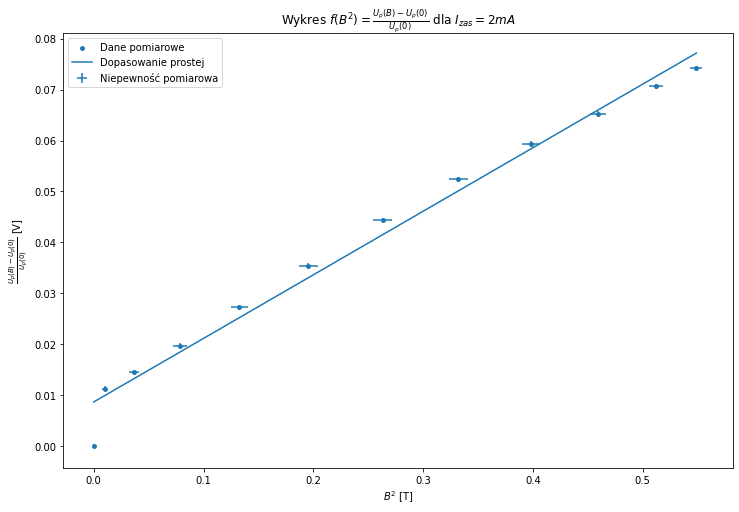

In [112]:
fig, ax = plt.subplots(figsize = (12, 8)) # add scienitfic notation for x axe
ax.scatter(new_df["B2"], new_df["(Ux-U)/U"], label = "Dane pomiarowe", s=15)
ax.plot(new_df["B2"], a2*new_df["B2"]+b2, label = "Dopasowanie prostej")
ax.errorbar(new_df["B2"], new_df["(Ux-U)/U"], xerr = new_df["uB2"], yerr = new_df["u(Ux-U/U)"], fmt = "none", label = "Niepewność pomiarowa")
ax.set_ylabel(r"$\frac{U_p(B)-U_p(0)}{U_p(0)}$ [V]")
ax.set_xlabel(r"$B^2$ [T]")
ax.set_title(r"Wykres $f(B^2)=\frac{U_p(B)-U_p(0)}{U_p(0)}$ dla $I_{zas}=2mA$")
ax.legend(loc=2)

fig.savefig("out/b2uuu.jpg", dpi = 800)
plt.show()